# Transform Experiments

custom transform

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from PIL import Image as pil_image

In [3]:
#pip3 install nvidia-ml-py3
import tracemalloc, threading, torch, time, pynvml
from fastai.utils.mem import *
from fastai.vision import *

In [4]:
import fastai
print(fastai.__version__)

1.0.43.dev0


In [5]:
torch.cuda.set_device(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
#see https://forums.fast.ai/t/gpu-optimizations-central/33944/15
#"memory profiler that taps into each epoch, and can be fine-tuned to each separate stage"
if not torch.cuda.is_available(): raise Exception("pytorch is required")

def preload_pytorch():
    torch.ones((1, 1)).cuda()
    
def gpu_mem_get_used_no_cache():
    torch.cuda.empty_cache()
    return gpu_mem_get().used

def gpu_mem_used_get_fast(gpu_handle):
    info = pynvml.nvmlDeviceGetMemoryInfo(gpu_handle)
    return int(info.used/2**20)

preload_pytorch()
pynvml.nvmlInit()

class PeakMemMetric(LearnerCallback):
    _order=-20 # Needs to run before the recorder

    def peak_monitor_start(self):
        self.peak_monitoring = True

In [7]:
path = Path('../data/mnist/mnist_png')

In [8]:
np.random.seed(42)

### No transforms

In [18]:
#no transforms
tfms = get_transforms(do_flip=False, 
                      flip_vert=False, 
                      max_rotate=0., 
                      max_zoom=0., 
                      max_lighting=0., 
                      max_warp=0., 
                      p_affine=0., 
                      p_lighting=0.)


In [19]:
data = ImageDataBunch.from_folder(path, valid_pct = 0.2,ds_tfms=tfms, size=28)

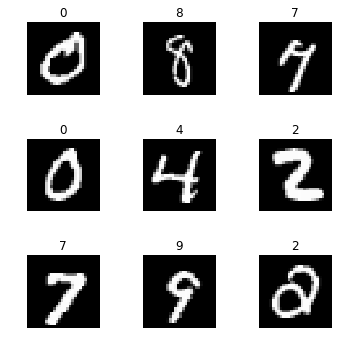

In [20]:
data.show_batch(rows=3, figsize=(5,5))

In [21]:
learn = create_cnn(data, models.resnet18, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


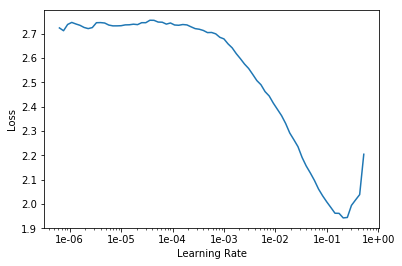

In [22]:
learn.lr_find()
learn.recorder.plot(skip_start=10, skip_end=5)


Notice how the lr vs loss plot is nice and smooth - but I have come accross datasets where it is really bumpy, lets create an example

### custom transforms

In [23]:
# Source of the code is based on an excelent piece code from stackoverflow
# http://stackoverflow.com/questions/22937589/how-to-add-noise-gaussian-salt-and-pepper-etc-to-image-in-python-with-opencv

def _noise_generator (image, noise_type):
    """
    Generate noise to a given Image based on required noise type
    
    Input parameters:
        image: ndarray (input image data. It will be converted to float)
        
        noise_type: string
            'gauss'        Gaussian-distrituion based noise
            'poission'     Poission-distribution based noise
            's&p'          Salt and Pepper noise, 0 or 1
            'speckle'      Multiplicative noise using out = image + n*image
                           where n is uniform noise with specified mean & variance
    """
    row,col,ch= image.shape
    if noise_type == "gauss":       
        mean = 0.0
        var = 0.01
        sigma = var**0.5
        gauss = np.array(image.shape)
        gauss = np.random.normal(mean,sigma,(row,col,ch))
        gauss = gauss.reshape(row,col,ch)
        noisy = image + gauss
        return noisy.astype('uint8')
    elif noise_type == "s&p":
        s_vs_p = 0.5
        amount = 0.004
        out = image
        # Generate Salt '1' noise
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
        out[coords] = 255
        # Generate Pepper '0' noise
        num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape]
        out[coords] = 0
        return out
    elif noise_type == "poisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
        return noisy
    elif noise_type =="speckle":
        gauss = np.random.randn(row,col,ch)
        gauss = gauss.reshape(row,col,ch)        
        noisy = image + image * gauss
        return noisy
    else:
        return image

In [40]:
def _gaussian_noise (image):
    #image.shape: torch.Size([3, 28, 28])
    row,col = image.shape[1:]
    ch=1
    mean = 0.0
    var = 0.5
    sigma = var**0.5
    gauss = np.array(image.shape)
    gauss = np.random.normal(mean,sigma,(ch,row,col))
    gauss = torch.Tensor(gauss.reshape(ch,row,col))
    noisy = image + gauss
    return noisy

In [41]:
gaussian_noise = TfmPixel(_gaussian_noise)


#### just the single transform

apply to train, but not validation set

In [42]:
tfms=[[gaussian_noise()],[]]

In [43]:
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=28)

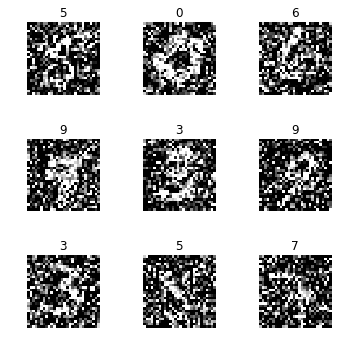

In [44]:
data.show_batch(rows=3, figsize=(5,5))

In [45]:
learn = create_cnn(data, models.resnet18, metrics=error_rate)

In [46]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


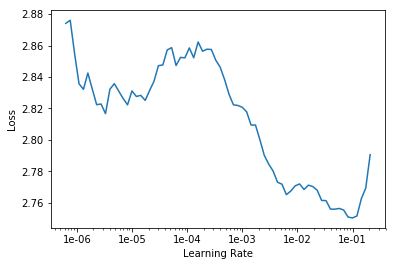

In [49]:
#I can never remember what these parameters are called so adding here (with defaults) for reference
learn.recorder.plot(skip_start=10, skip_end=10)

### Default transforms plus custom transform

In [50]:
tfms = get_transforms(do_flip=True, flip_vert=False, max_rotate=10.0, max_zoom=1.1, max_lighting=0.2, max_warp=0.2, p_affine=0.75, p_lighting=0.75, xtra_tfms=[gaussian_noise()])

In [51]:
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=28)

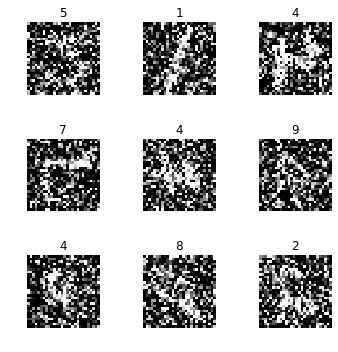

In [52]:
data.show_batch(rows=3, figsize=(5,5))

In [53]:
learn = create_cnn(data, models.resnet18, metrics=error_rate)

In [54]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


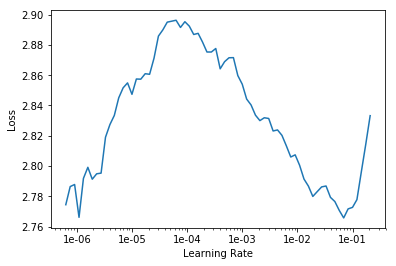

In [55]:
learn.recorder.plot(skip_start=10, skip_end=10)